https://zzcojoa.tistory.com/91

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.9 MB/s 


In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.9 MB/s 


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [5]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [6]:
data_dir = '/content/drive/MyDrive/data'
model_dir = '/content/drive/MyDrive/model'

# 훈련데이터 확인
train_json_path = data_dir + '/train_data.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- creator: MINDs Lab.
- version: 1
- data: [60000]
  - paragraphs: [1]
    - qas: [1]
      - question: 다테 기미코가 최초로 은퇴 선언을 한게 언제지
      - answers: [1]
        - answer_start: 260
        - text: 1996년 9월 24일
      - id: 9_f2_wiki_2822-1
    - context: 재팬 오픈에서 4회 우승하였으며, 통산 단식 200승 이상을 거두었다. 1994년 생애 최초로 세계 랭킹 10위권에 진입하였다. 1992년에는 WTA로부터 '올해 가장 많은 향상을 보여준 선수상'(Most Improved Player Of The Year)을 수여받았으며, 일본 남자 패션 협회(Japan Men's Fashion Association)는 그녀를 '가장 패셔너블한 선수'(Most Fashionable)로 칭했다. 생애 두 번째 올림픽 참가 직후인 1996년 9월 24일 최초로 은퇴를 선언하였다. 이후 12년만인 2008년 4월에 예상치 못한 복귀 선언을 하고 투어에 되돌아왔다. 2008년 6월 15일 도쿄 아리아케 인터내셔널 여자 오픈에서 복귀 후 첫 우승을 기록했으며, 2009년 9월 27일에는 한국에서 열린 한솔 코리아 오픈 대회에서 우승하면서 복귀 후 첫 WTA 투어급 대회 우승을 기록했다. 한숨 좀 작작 쉬어!
  - title: 다테_기미코


In [7]:
# 검증데이터 확인
dev_json_path = data_dir + '/test_data.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- creator: MINDs Lab.
- version: 1
- data: [8538]
  - paragraphs: [1]
    - qas: [1]
      - question: 패밀리가 떴다는 어디에서 방송했어
      - answers: [1]
        - answer_start: 167
        - text: SBS
      - id: 8_C60_wiki_1818-1
    - context: 2010년 2월 14일 패밀리가 떴다가 종영되고, 패밀리가 떴다 2가 2월 21일 방영되었다. 《패밀리가 떴다》는 2008년 3월부터 제작을 시작하였으며, 2008년 6월 15일 첫방송 되었다. 준말로 ‘패떴’으로 불리기도 한다. 2008년 8월 31일, 처음으로 시청률 20%를 돌파하였으며 이후 SBS의 대표 예능 프로그램으로 자리잡았다. 시골에 찾아가 할아버지·할머니를 여행 보내드리고 집을 봐드리면서 벌어지는 에피소드를 담는다. 할아버지·할머니께서 부탁하신 일을 하면서 게임을 하고, 식사를 같이 하면서 벌어지는 1박 2일의 모습을 보여주는 프로그램이다. 《패밀리가 떴다》의 고정 출연진은 이천희를 포함하여 총 7명이다.
  - title: 패밀리가 떴다


- 원본

In [8]:
print(json.dumps(train_json["data"][0:10], indent=2, ensure_ascii=False))

[
  {
    "paragraphs": [
      {
        "qas": [
          {
            "question": "다테 기미코가 최초로 은퇴 선언을 한게 언제지",
            "answers": [
              {
                "answer_start": 260,
                "text": "1996년 9월 24일"
              }
            ],
            "id": "9_f2_wiki_2822-1"
          }
        ],
        "context": "재팬 오픈에서 4회 우승하였으며, 통산 단식 200승 이상을 거두었다. 1994년 생애 최초로 세계 랭킹 10위권에 진입하였다. 1992년에는 WTA로부터 '올해 가장 많은 향상을 보여준 선수상'(Most Improved Player Of The Year)을 수여받았으며, 일본 남자 패션 협회(Japan Men's Fashion Association)는 그녀를 '가장 패셔너블한 선수'(Most Fashionable)로 칭했다. 생애 두 번째 올림픽 참가 직후인 1996년 9월 24일 최초로 은퇴를 선언하였다. 이후 12년만인 2008년 4월에 예상치 못한 복귀 선언을 하고 투어에 되돌아왔다. 2008년 6월 15일 도쿄 아리아케 인터내셔널 여자 오픈에서 복귀 후 첫 우승을 기록했으며, 2009년 9월 27일에는 한국에서 열린 한솔 코리아 오픈 대회에서 우승하면서 복귀 후 첫 WTA 투어급 대회 우승을 기록했다. 한숨 좀 작작 쉬어!"
      }
    ],
    "title": "다테_기미코"
  },
  {
    "paragraphs": [
      {
        "qas": [
          {
            "question": "ave;new 본거지 어디야",
            "answers": [
            

In [9]:
print(json.dumps(dev_json["data"][130:140], indent=2, ensure_ascii=False))

[
  {
    "paragraphs": [
      {
        "qas": [
          {
            "question": "러시아의 집이나 식당에서 가장 흔히 제공하는 수프는",
            "answers": [
              {
                "answer_start": 136,
                "text": "보르시"
              }
            ],
            "id": "9_f7_wiki_1700-1"
          }
        ],
        "context": "기름기를 띄며 신맛이 강하다. 영어식 표기인 'borshch'를 그대로 옮겨 적어 '보르시치'라고 잘못 표기되는 경우가 많다. 원래는 우크라이나가 원조라고 생각되지만 동유럽과 중앙유럽 여러 나라에서 널리 선호하는 요리이다. 특히 러시아의 경우 보르시는 대표적 전통 음식으로 여겨진다. 러시아 국민들은 사계절 내내 이를 즐겨 먹곤 하며, 집이나 식당에서 가장 흔히 제공하는 수프이다. 사탕무, 양파, 당근, 쇠고기 등의 재료를 볶고 나서 수프로 천천히 삶아서 만든다. 그 외의 건더기로 소시지, 햄, 베이컨, 닭고기 등의 육류 등을 사용하기도 한다."
      }
    ],
    "title": "보르시"
  },
  {
    "paragraphs": [
      {
        "qas": [
          {
            "question": "트루컬러는 색 몇 개 쓸 수 있어",
            "answers": [
              {
                "answer_start": 33,
                "text": "16,777,216"
              }
            ],
            "id": "8_C46_wiki_2802-1"
          },
          {


## KorQuAD 데이터셋 전처리 (1) 띄어쓰기 단위 정보관리

In [10]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [11]:
# whitespace가 2개인 경우를 처리해야 함

string1 = '1839년 파우스트를 읽었다.'
string2 = '1839년  파우스트를 읽었다.'
string1[6:10], string2[7:11]

('파우스트', '파우스트')

In [12]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
for c in string1:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'년' : ['1839년'] : [0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0]
'파' : ['1839년', '파'] : [0, 0, 0, 0, 0, 0, 1]
'우' : ['1839년', '파우'] : [0, 0, 0, 0, 0, 0, 1, 1]
'스' : ['1839년', '파우스'] : [0, 0, 0, 0, 0, 0, 1, 1, 1]
'트' : ['1839년', '파우스트'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽' : ['1839년', '파우스트를', '읽'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었' : ['1839년', '파우스트를', '읽었'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['1839년', '파우스트를', '읽었다'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839년', '파우스트를', '읽었다.'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


In [13]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
for c in string2:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'년' : ['1839년'] : [0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0, 0]
'파' : ['1839년', '파'] : [0, 0, 0, 0, 0, 0, 0, 1]
'우' : ['1839년', '파우'] : [0, 0, 0, 0, 0, 0, 0, 1, 1]
'스' : ['1839년', '파우스'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
'트' : ['1839년', '파우스트'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽' : ['1839년', '파우스트를', '읽'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었' : ['1839년', '파우스트를', '읽었'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['1839년', '파우스트를', '읽었다'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839년', '파우스트를', '읽었다.'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


In [14]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

In [15]:
# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [16]:
# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

## 데이터셋 전처리 (2) Tokenize by Vocab

In [17]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

# word를 subword로 변경하면서 index 저장
word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)  # SentencePiece를 사용해 Subword로 쪼갭니다.
    for token in tokens:
        context_tokens.append(token)

context_tokens, word_to_token

(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

In [18]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [19]:
print(word_tokens)  # 처리해야 할 word 단위 입력

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token   # Subword 단위로 토큰화한 결과

['1839년', '파우스트를', '읽었다.']


(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

###KorQuAD 데이터셋 전처리 (3) Improve Span

In [20]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  재팬 오픈에서 4회 우승하였으며, 통산 단식 200승 이상을 거두었다. 1994년 생애 최초로 세계 랭킹 10위권에 진입하였다. 1992년에는 WTA로부터 '올해 가장 많은 향상을 보여준 선수상'(Most Improved Player Of The Year)을 수여받았으며, 일본 남자 패션 협회(Japan Men's Fashion Association)는 그녀를 '가장 패셔너블한 선수'(Most Fashionable)로 칭했다. 생애 두 번째 올림픽 참가 직후인 1996년 9월 24일 최초로 은퇴를 선언하였다. 이후 12년만인 2008년 4월에 예상치 못한 복귀 선언을 하고 투어에 되돌아왔다. 2008년 6월 15일 도쿄 아리아케 인터내셔널 여자 오픈에서 복귀 후 첫 우승을 기록했으며, 2009년 9월 27일에는 한국에서 열린 한솔 코리아 오픈 대회에서 우승하면서 복귀 후 첫 WTA 투어급 대회 우승을 기록했다. 한숨 좀 작작 쉬어!
[question]  다테 기미코가 최초로 은퇴 선언을 한게 언제지
[answer]  1996년 9월 24일
[answer_start] index:  260 character:  1
[answer_end]index:  271 character:  일


In [21]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['재팬', '오픈에서', '4회', '우승하였으며,', '통산', '단식', '200승', '이상을', '거두었다.', '1994년', '생애', '최초로', '세계', '랭킹', '10위권에', '진입하였다.', '1992년에는', 'WTA로부터', "'올해", '가장']


([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4],
 '재팬 오픈에서 4회 우승하였으며, 통')

In [22]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁재팬']
1 ['▁오픈', '에서']
3 ['▁4', '회']
5 ['▁우승', '하였으며', ',']
8 ['▁통산']
9 ['▁단식']
10 ['▁200', '승']
12 ['▁이상을']
13 ['▁거두었다', '.']
15 ['▁1994', '년']
17 ['▁생애']
18 ['▁최초로']
19 ['▁세계']
20 ['▁랭킹']
21 ['▁10', '위권', '에']
24 ['▁진입', '하였다', '.']
27 ['▁1992', '년에는']
29 ['▁W', 'TA', '로부터']
32 ["▁'", '올', '해']
35 ['▁가장']


In [23]:
# answer_start와 answer_end로부터 word_start와 word_end를 구합니다. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(49, 51, '1996년 9월 24일', ['1996년', '9월', '24일'])

In [24]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(104, 109, ['▁1996', '년', '▁9', '월', '▁24', '일'])

In [25]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁1996 년 ▁9 월 ▁24 일'

In [26]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

O >> (104, 109) ▁1996 년 ▁9 월 ▁24 일
X >> (104, 108) ▁1996 년 ▁9 월 ▁24
X >> (104, 107) ▁1996 년 ▁9 월
X >> (104, 106) ▁1996 년 ▁9
X >> (104, 105) ▁1996 년
X >> (104, 104) ▁1996
X >> (105, 109) 년 ▁9 월 ▁24 일
X >> (105, 108) 년 ▁9 월 ▁24
X >> (105, 107) 년 ▁9 월
X >> (105, 106) 년 ▁9
X >> (105, 105) 년
X >> (106, 109) ▁9 월 ▁24 일
X >> (106, 108) ▁9 월 ▁24
X >> (106, 107) ▁9 월
X >> (106, 106) ▁9
X >> (107, 109) 월 ▁24 일
X >> (107, 108) 월 ▁24
X >> (107, 107) 월
X >> (108, 109) ▁24 일
X >> (108, 108) ▁24
X >> (109, 109) 일


In [27]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [28]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 104  token_end: 109


['▁1996', '년', '▁9', '월', '▁24', '일']

## 데이터셋 전처리 (4) 데이터셋 분리

In [29]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    if char_answer not in word_answer:
                      break                  

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    #print(data)
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [ ]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, "/content/drive/MyDrive/AI_hub/TRAIN.json")
dump_korquad(vocab, dev_json, "/content/drive/MyDrive/AI_hub/TEST.json")

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/8538 [00:00<?, ?it/s]

In [32]:
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(data_dir + '/TRAIN_preprocessing.json') #####

{"qa_id": "9_f2_wiki_2822-1", "title": "다테_기미코", "question": ["▁다테", "▁기미", "코가", "▁최초로", "▁은퇴", "▁선언을", "▁한", "게", "▁언제", "지"], "context": ["▁재팬", "▁오픈", "에서", "▁4", "회", "▁우승", "하였으며", ",", "▁통산", "▁단식", "▁200", "승", "▁이상을", "▁거두었다", ".", "▁1994", "년", "▁생애", "▁최초로", "▁세계", "▁랭킹", "▁10", "위권", "에", "▁진입", "하였다", ".", "▁1992", "년에는", "▁W", "TA", "로부터", "▁'", "올", "해", "▁가장", "▁많은", "▁향상을", "▁보여준", "▁선수", "상", "'(", "M", "ost", "▁", "Imp", "ro", "v", "ed", "▁P", "layer", "▁Of", "▁The", "▁Year", ")", "을", "▁수여", "받았으며", ",", "▁일본", "▁남자", "▁패션", "▁협회", "(", "Ja", "pan", "▁M", "en", "'", "s", "▁F", "ash", "ion", "▁Association", ")", "는", "▁그녀를", "▁'", "가", "장", "▁패", "셔", "너", "블", "한", "▁선수", "'(", "M", "ost", "▁F", "ash", "ion", "able", ")", "로", "▁칭", "했다", ".", "▁생애", "▁두", "▁번째", "▁올림픽", "▁참가", "▁직후인", "▁1996", "년", "▁9", "월", "▁24", "일", "▁최초로", "▁은퇴", "를", "▁선언하였다", ".", "▁이후", "▁12", "년", "만", "인", "▁2008", "년", "▁4", "월에", "▁예상", "치", "▁못한", "▁복귀", "▁선언을", "▁하고", "▁투어", "에", "▁되

In [33]:
print_file(data_dir + '/TEST_preprocessing.json') #####

{"qa_id": "8_C60_wiki_1818-1", "title": "패밀리가 떴다", "question": ["▁패밀리", "가", "▁", "떴", "다", "는", "▁어디", "에서", "▁방송", "했어"], "context": ["▁2010", "년", "▁2", "월", "▁14", "일", "▁패밀리", "가", "▁", "떴", "다가", "▁종영", "되고", ",", "▁패밀리", "가", "▁", "떴", "다", "▁2", "가", "▁2", "월", "▁21", "일", "▁방영되었다", ".", "▁《", "패", "밀리", "가", "▁", "떴", "다", "》", "는", "▁2008", "년", "▁3", "월부터", "▁제작을", "▁시작하였으며", ",", "▁2008", "년", "▁6", "월", "▁15", "일", "▁첫", "방송", "▁되었다", ".", "▁준", "말", "로", "▁‘", "패", "떴", "’", "으로", "▁불리기도", "▁한다", ".", "▁2008", "년", "▁8", "월", "▁31", "일", ",", "▁처음으로", "▁시청률", "▁20%", "를", "▁돌파", "하였으며", "▁이후", "▁SBS", "의", "▁대표", "▁예능", "▁프로그램으로", "▁자리잡았다", ".", "▁시골", "에", "▁찾아가", "▁할아버지", "·", "할", "머니", "를", "▁여행", "▁보내", "드리", "고", "▁집을", "▁봐", "드리", "면서", "▁벌어지는", "▁에피소드", "를", "▁담", "는", "다", ".", "▁할아버지", "·", "할", "머니", "께서", "▁부탁", "하신", "▁일을", "▁하면서", "▁게임을", "▁하고", ",", "▁식사", "를", "▁같이", "▁하면서", "▁벌어지는", "▁1", "박", "▁2", "일", "의", "▁모습을", "▁보여주는", "▁프로그램이다", ".", "▁《", "패", "밀

## KorQuAD 데이터셋 전처리 (5) 데이터 분석 : Question

In [34]:
questions = []
contexts = []
token_starts = []
with open(data_dir + '/TRAIN_preprocessing.json') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

104 ['▁다테', '▁기미', '코가', '▁최초로', '▁은퇴', '▁선언을', '▁한', '게', '▁언제', '지']
18 ['▁', 'ave', ';', 'new', '▁본거지', '▁어디', '야']
94 ['▁사카이', '▁다다요시', '의', '▁아버지가', '▁누구', '지']
36 ['▁일반', '성', '면', '의', '▁면적이', '▁얼마', '야']
128 ['▁금나라', '를', '▁세운', '▁사람이', '▁누구', '야']
59 ['▁스', '냅', '이', '▁뭐', '야']
76 ['▁포', '클', '랜드', '제도', '에', '▁대한', '▁UN', '의', '▁입장', '은', '▁뭐', '야']
93 ['▁2014', '년', '▁지금', '▁북한이', '▁잠수함', '을', '▁몇', '개', '▁가졌다', '고', '▁알려져', '▁있어']
19 ['▁김병', '지가', '▁언제', '▁데뷔', '했어']
68 ['▁케이', '티', '▁페리', '의', '▁직업', '은', '▁뭐', '야']


In [35]:
questions = []
contexts = []
token_starts = []
with open(data_dir + '/TEST_preprocessing.json') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

78 ['▁패밀리', '가', '▁', '떴', '다', '는', '▁어디', '에서', '▁방송', '했어']
153 ['▁노', '네', '임', '의', '▁종류는', '▁몇', '▁가지', '야']
155 ['▁하이', '데', '▁로', '젠', '달', '의', '▁아들', '은']
102 ['▁디아', '블로', '▁2', '의', '▁프로듀서', '가', '▁누구', '야']
28 ['▁야', '니', '차', '▁코스', '텔리', '치는', '▁어느', '▁나라', '▁알파', '인', '▁스키', '선수', '야']
0 ['▁두', '▁번째로', '▁그랜드', '슬', '램', '을', '▁달성한', '▁알파', '인', '▁스키', '▁선수가', '▁누구', '야']
28 ['▁스키', '선수', '▁야', '니', '차', '▁코스', '텔리', '치의', '▁국적', '▁알려', '줘']
40 ['▁2002', '년', '▁동계올림픽', '에서', '▁코스', '텔리', '치가', '▁수상한', '▁금메달', '▁숫자', '▁알려', '줘']
86 ['▁2006', '년까지', '▁코스', '텔리', '치가', '▁스키', '▁주요', '▁종목에서', '▁몇', '▁개의', '▁금메달을', '▁획득', '했', '지']
0 ['▁그랜드', '슬', '램', '을', '▁두번째', '로', '▁달성한', '▁알파', '인', '▁스키', '▁선수', '▁이름이', '▁뭐', '지']


In [36]:
# token count
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[10, 8, 8, 8, 13, 13, 11, 12, 14, 14]

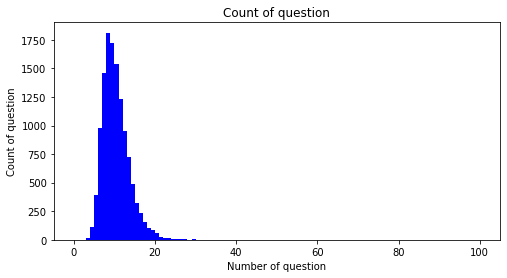

In [37]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
# 그래프 제목
plt.title('Count of question')
# 그래프 x 축 라벨
plt.xlabel('Number of question')
# 그래프 y 축 라벨
plt.ylabel('Count of question')
plt.show()

In [38]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      32
question 길이 최소:       1
question 길이 평균:       9.86
question 길이 표준편차:    3.22
question 25/100분위:     8.00
question 50/100분위:     9.00
question 75/100분위:    12.00
question IQR:           4.00
question MAX/100분위:   18.00


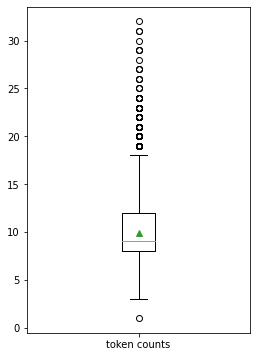

In [39]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

## 데이터셋 전처리 (6) 데이터 분석 : Context

In [40]:
# token count
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[154, 271, 168, 190, 233, 233, 233, 233, 233, 233]

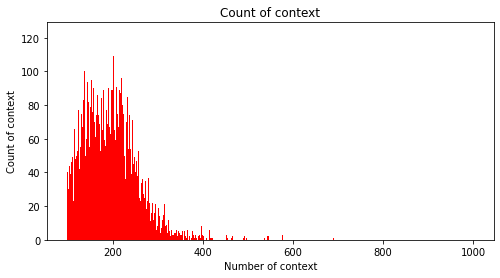

In [41]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
# 그래프 제목
plt.title('Count of context')
# 그래프 x 축 라벨
plt.xlabel('Number of context')
# 그래프 y 축 라벨
plt.ylabel('Count of context')
plt.show()

In [42]:
# 데이터 길이
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:     689
context 길이 최소:      33
context 길이 평균:     190.88
context 길이 표준편차:   60.46
context 25/100분위:   146.00
context 50/100분위:   187.00
context 75/100분위:   227.00
context IQR:          81.00
context MAX/100분위:  348.50


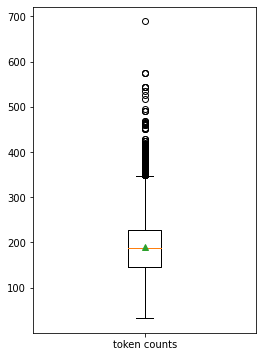

In [43]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

## 데이터셋 전처리 (7) 데이터 분석 : Answer

In [44]:
# token count
train_answer_starts = token_starts
train_answer_starts[:10]

[78, 153, 155, 102, 28, 0, 28, 40, 86, 0]

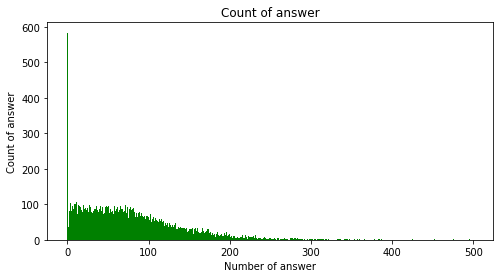

In [45]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
# 그래프 제목
plt.title('Count of answer')
# 그래프 x 축 라벨
plt.xlabel('Number of answer')
# 그래프 y 축 라벨
plt.ylabel('Count of answer')
plt.show()

In [46]:
# 데이터 길이
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:     495
answer 위치 최소:       0
answer 위치 평균:      77.06
answer 위치 표준편차:   60.80
answer 25/100분위:    29.00
answer 50/100분위:    67.00
answer 75/100분위:   110.00
answer IQR:          81.00
answer MAX/100분위:  231.50


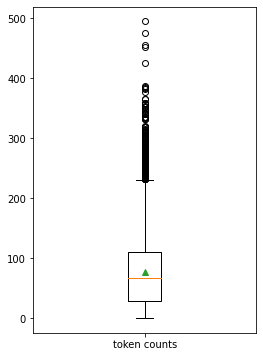

In [47]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

## 데이터셋 전처리 (8) 데이터 분석 : Word Cloud

In [48]:
# train documents
documents = []

# 전체 데이터에서 title, context, question 문장을 모두 추출합니다. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]   # 그중 맨 앞 10개만 확인해 봅니다.

  0%|          | 0/60000 [00:00<?, ?it/s]

['다테_기미코',
 "재팬 오픈에서 4회 우승하였으며, 통산 단식 200승 이상을 거두었다. 1994년 생애 최초로 세계 랭킹 10위권에 진입하였다. 1992년에는 WTA로부터 '올해 가장 많은 향상을 보여준 선수상'(Most Improved Player Of The Year)을 수여받았으며, 일본 남자 패션 협회(Japan Men's Fashion Association)는 그녀를 '가장 패셔너블한 선수'(Most Fashionable)로 칭했다. 생애 두 번째 올림픽 참가 직후인 1996년 9월 24일 최초로 은퇴를 선언하였다. 이후 12년만인 2008년 4월에 예상치 못한 복귀 선언을 하고 투어에 되돌아왔다. 2008년 6월 15일 도쿄 아리아케 인터내셔널 여자 오픈에서 복귀 후 첫 우승을 기록했으며, 2009년 9월 27일에는 한국에서 열린 한솔 코리아 오픈 대회에서 우승하면서 복귀 후 첫 WTA 투어급 대회 우승을 기록했다. 한숨 좀 작작 쉬어!",
 '다테 기미코가 최초로 은퇴 선언을 한게 언제지',
 'Ave;new',
 'ave;new(아베;뉴, アベニュー)는 도쿄 치요다구에 본 거처를 둔 일본의 음악 제작 그룹이다. ave;new의 프로듀서인 a.k.a.dRESS가 학창시절부터 친구인 네모토 히데미·마츠시타 미유키를 불러 사운드 팀을 시작하자고 제안한 것이 결성의 계기이다. 2003년 7월에 결성된 ave;new는, 주로성인 게임의 주제가나 BGM를 제공하고 있다.주로 파트너 브랜드의 BGM 및 예능 프로덕션도 담당하고 있으며 CD는 그룹명과 같이 ave;new의 라벨로 판매되고 있으나 다른 라벨에 비해 시장에 약간 유통 하기 어렵다.또한 일부의 CD는 d;VIRTU(주식회사 디바트)가 판매하고 있기 때문이다. 음악은테크노계나 트랜스계와 같이 밝은 곡으로부터,재즈나발라드와 같이 조용한 곡까지 폭넓게 제작할 수 있는 것이 특징이다.특히, 신디사이저를 이용한 테크노계의 곡은 높은 평가를 얻고있다. ave;new의 프로듀서인a.k.a.dRESS가 학

In [49]:
# documents를 전부 이어 하나의 문장으로 만들면 이렇게 보입니다. 
" ".join(documents[:10])

'다테_기미코 재팬 오픈에서 4회 우승하였으며, 통산 단식 200승 이상을 거두었다. 1994년 생애 최초로 세계 랭킹 10위권에 진입하였다. 1992년에는 WTA로부터 \'올해 가장 많은 향상을 보여준 선수상\'(Most Improved Player Of The Year)을 수여받았으며, 일본 남자 패션 협회(Japan Men\'s Fashion Association)는 그녀를 \'가장 패셔너블한 선수\'(Most Fashionable)로 칭했다. 생애 두 번째 올림픽 참가 직후인 1996년 9월 24일 최초로 은퇴를 선언하였다. 이후 12년만인 2008년 4월에 예상치 못한 복귀 선언을 하고 투어에 되돌아왔다. 2008년 6월 15일 도쿄 아리아케 인터내셔널 여자 오픈에서 복귀 후 첫 우승을 기록했으며, 2009년 9월 27일에는 한국에서 열린 한솔 코리아 오픈 대회에서 우승하면서 복귀 후 첫 WTA 투어급 대회 우승을 기록했다. 한숨 좀 작작 쉬어! 다테 기미코가 최초로 은퇴 선언을 한게 언제지 Ave;new ave;new(아베;뉴, アベニュー)는 도쿄 치요다구에 본 거처를 둔 일본의 음악 제작 그룹이다. ave;new의 프로듀서인 a.k.a.dRESS가 학창시절부터 친구인 네모토 히데미·마츠시타 미유키를 불러 사운드 팀을 시작하자고 제안한 것이 결성의 계기이다. 2003년 7월에 결성된 ave;new는, 주로성인 게임의 주제가나 BGM를 제공하고 있다.주로 파트너 브랜드의 BGM 및 예능 프로덕션도 담당하고 있으며 CD는 그룹명과 같이 ave;new의 라벨로 판매되고 있으나 다른 라벨에 비해 시장에 약간 유통 하기 어렵다.또한 일부의 CD는 d;VIRTU(주식회사 디바트)가 판매하고 있기 때문이다. 음악은테크노계나 트랜스계와 같이 밝은 곡으로부터,재즈나발라드와 같이 조용한 곡까지 폭넓게 제작할 수 있는 것이 특징이다.특히, 신디사이저를 이용한 테크노계의 곡은 높은 평가를 얻고있다. ave;new의 프로듀서인a.k.a.dRESS가 학생시절부터의 친구인 네

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


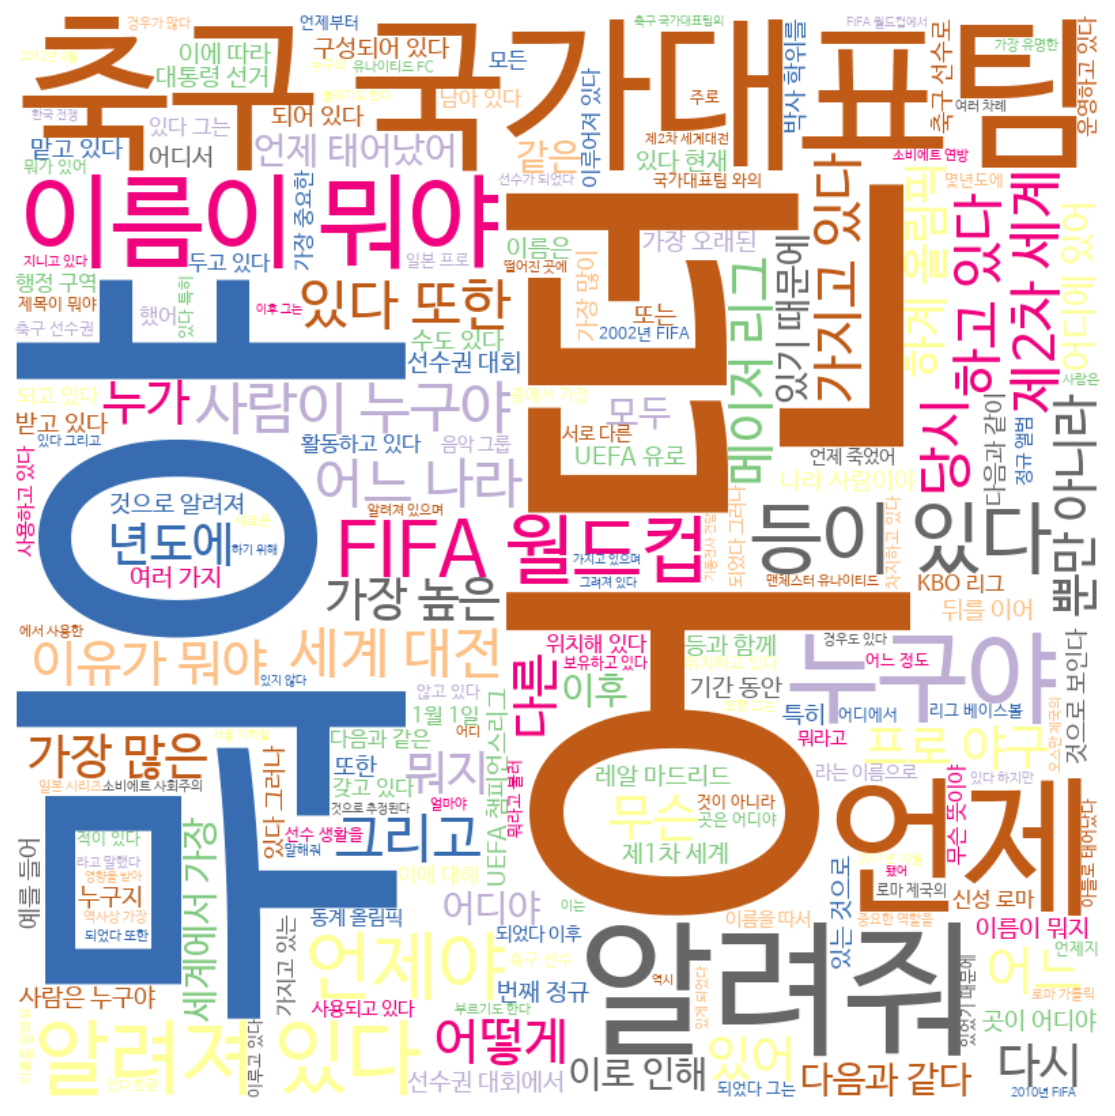

In [51]:
# WordCloud로 " ".join(documents)를 처리해 봅니다. 
wordcloud = WordCloud(
    width=800, 
    height=800,
    background_color='white',
    colormap='Accent_r',
    font_path=fontpath
    ).generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 데이터셋 전처리 (9) 데이터 로드

In [52]:
train_json = os.path.join(data_dir + '/TRAIN_preprocessing.json')
dev_json = os.path.join(data_dir + '/TEST_preprocessing.json') 

In [53]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

In [54]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):

          data = json.loads(line)
          token_start = data.get("token_start")
          token_end = data.get("token_end")
          question = data["question"][:args.max_query_length]
          context = data["context"]
          answer_tokens = " ".join(context[token_start:token_end + 1])
          context_len = args.max_seq_length - len(question) - 3

          if token_end >= context_len:
              # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
              n_discard += 1
              continue
          context = context[:context_len]
          assert len(question) + len(context) <= args.max_seq_length - 3

          tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
          ids = [vocab.piece_to_id(token) for token in tokens]
          ids += [0] * (args.max_seq_length - len(ids))
          inputs.append(ids)
          segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
          segs += [0] * (args.max_seq_length - len(segs))
          segments.append(segs)
          token_start += (len(question) + 2)
          labels_start.append(token_start)
          token_end += (len(question) + 2)
          labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [70]:
with tf.device('device:GPU:0'):
# train data load
  train_inputs, train_labels = load_data(args, train_json)
  print(f"train_inputs: {train_inputs[0].shape}")
  print(f"train_inputs: {train_inputs[1].shape}")
  print(f"train_labels: {train_labels[0].shape}")
  print(f"train_labels: {train_labels[1].shape}")

  # dev data load
  dev_inputs, dev_labels = load_data(args, dev_json)
  print(f"dev_inputs: {dev_inputs[0].shape}")
  print(f"dev_inputs: {dev_inputs[1].shape}")
  print(f"dev_labels: {dev_labels[0].shape}")
  print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 64
train_inputs: (87716, 384)
train_inputs: (87716, 384)
train_labels: (87716,)
train_labels: (87716,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 12
dev_inputs: (12440, 384)
dev_inputs: (12440, 384)
dev_labels: (12440,)
dev_labels: (12440,)


((array([[    5, 13787, 24839, ...,     0,     0,     0],
         [    5,    11,  8904, ...,     0,     0,     0],
         [    5, 12323, 28608, ...,     0,     0,     0],
         ...,
         [    5, 24572,  2007, ...,     0,     0,     0],
         [    5,    11, 27860, ...,     0,     0,     0],
         [    5,   383,    13, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([116,  27, 102, ...,  28,  45, 165]),
  array([121,  31, 110, ...,  36,  50, 166])))

In [56]:
# Question과 Context가 포함된 입력데이터 1번째
train_inputs[0][0]

array([    5, 13787, 24839, 10305,  1053,  2323, 18778,    58,   139,
        9675,    47,     4, 18404,  2804,    22,    46,   168,   908,
         450,     8,  4256, 11030,  1570,   470,  6298,  4280,     7,
        1218,    15,  6315,  1053,   238,  7410,    66, 14432,    13,
        3444,    54,     7,  1238,   308,   777,  5884,   420,    62,
        2194,    60,   141,   189, 18762, 16941,   611,   121,  3112,
         579,  8970,    11, 27598,  1772,  2613,  1181,   599, 27915,
       15461,  2007, 27103,    12,    16,  4652, 16634,     8,   146,
        1020,  5060,  2633,    14, 17052, 21492,   476,  1173,    56,
         162,   540, 13273,  3032, 20074,    12,    10,  6602,    62,
          19,   148,  1168,  2681,   827,  1761,    33,   611,  3112,
         579,  8970,   540, 13273,  3032, 12684,    12,    21,  2905,
          53,     7,  6315,    98,   407,   569,  2107, 22606,  1153,
          15,    81,    23,   544,    28,  1053,  2323,    20, 11152,
           7,    83,

In [57]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]

(116, 121)

##LSTM을 이용해보자.¶

우선 KorQuAD 태스크를 LSTM 모델을 활용하여 학습해 보자.
다소 복잡해 보이겠지만 Input이 2개, Output이 2개인 모델이라는 점에 주목하자.
2개의 Input은 이전 스텝에서 보았던 train_inputs[0], train_inputs[1] 이 들어간다.
각각 Question+Context 의 데이터와 Segment 이다.
그리고 Output은 Answer의 시작점과 끝점의 위치입니다.

In [ ]:
def build_model_lstm(n_vocab, n_seq, d_model):
    tokens = tf.keras.layers.Input((None,), name='tokens')
    segments = tf.keras.layers.Input((None,), name='segments')

    hidden = tf.keras.layers.Embedding(n_vocab, d_model)(tokens) + tf.keras.layers.Embedding(2, d_model)(segments) # (bs, n_seq, d_model)

    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.Dense(2)(hidden) # (bs, n_seq, 2)
    start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)
    start_logits = tf.squeeze(start_logits, axis=-1)  # (bs, n_seq)
    start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)
    end_logits = tf.squeeze(end_logits, axis=-1)  # (bs, n_seq)
    end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

    model = tf.keras.Model(inputs=(tokens, segments), outputs=(start_outputs, end_outputs))
    return model

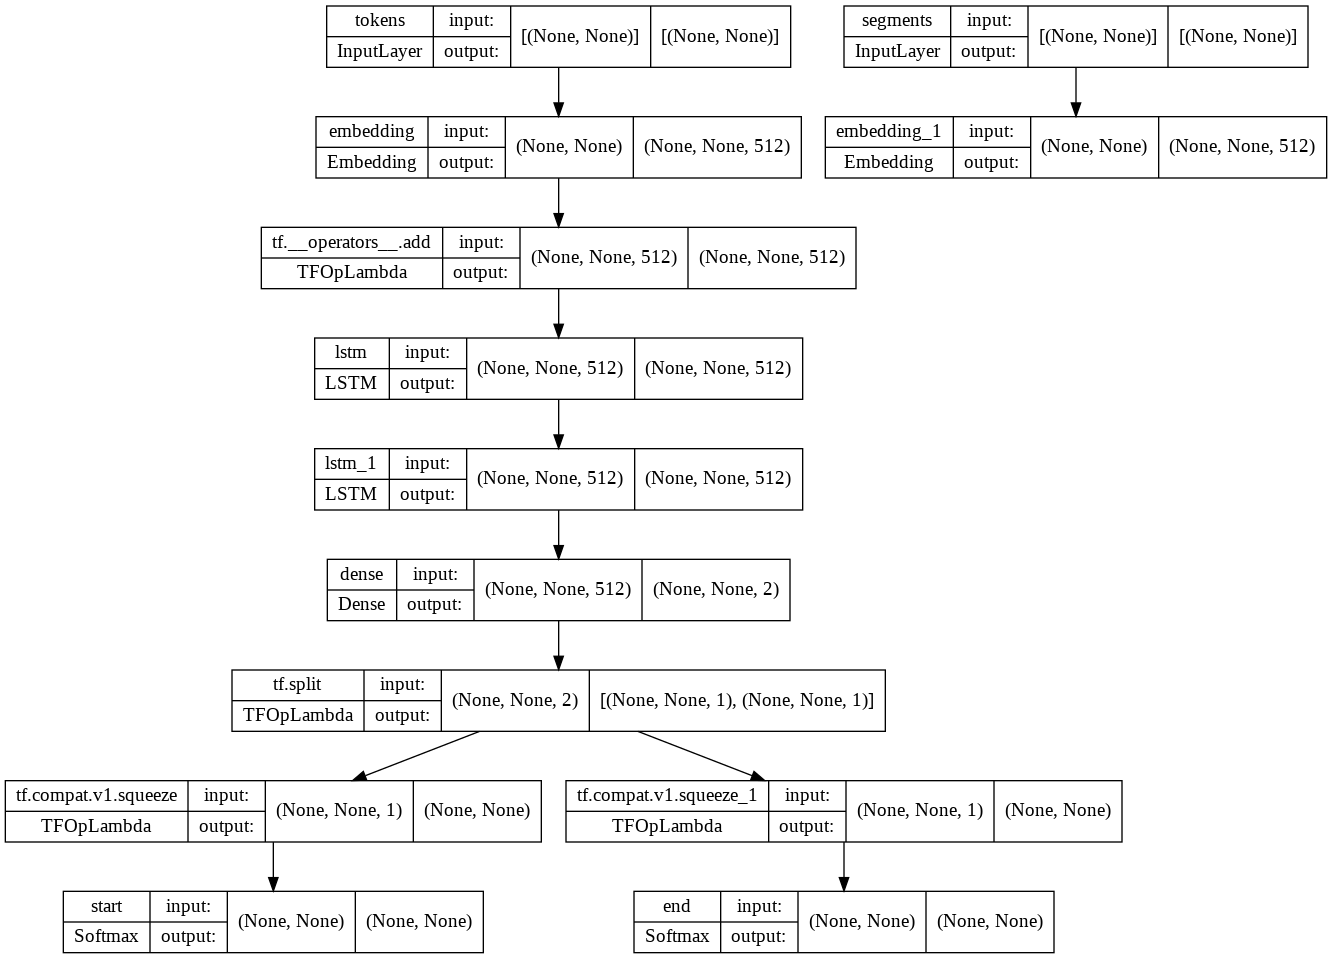

In [ ]:
model = build_model_lstm(n_vocab=len(vocab), n_seq=512, d_model=512)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_start_accuracy', patience=3)
# save weights
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, "korquad_lstm.hdf5"), monitor='val_start_accuracy', verbose=1, save_best_only=True, mode='max', save_freq='epoch', save_weights_only=True)

history = model.fit(train_inputs, train_labels, epochs=10, batch_size=128, validation_data=(dev_inputs, dev_labels), callbacks=[early_stopping, save_weights])

Epoch 1/10
181/686 [======>.......................] - ETA: 4:26:43 - loss: 9.5016 - start_loss: 4.6225 - end_loss: 4.8791 - start_accuracy: 0.0549 - end_accuracy: 0.0500

KeyboardInterrupt: ignored

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


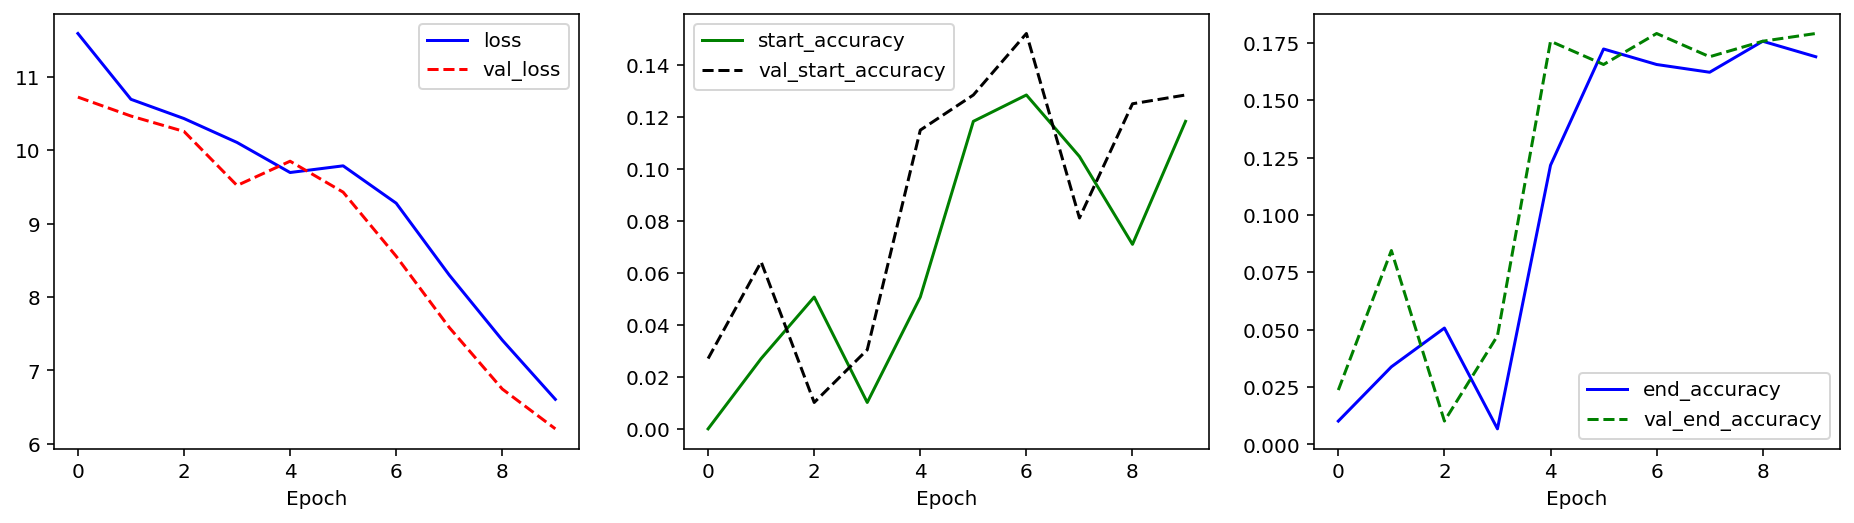

In [ ]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['start_accuracy'], 'g-', label='start_accuracy')
plt.plot(history.history['val_start_accuracy'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['end_accuracy'], 'b-', label='end_accuracy')
plt.plot(history.history['val_end_accuracy'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## BERT

In [59]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [60]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [61]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [62]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [63]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [64]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [65]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [66]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [67]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

### BERT 모델을 이용한 도전¶

BERT 모델을 활용하여, LSTM으로 풀어보았던 KorQuAD 태스크를 다시 학습해 보자.
모델의 차이만 비교해 보기 위해 일부러 두 모델이 사용하는 Tokenizer를 동일하게 구성하다.
아래는 BERT 레이어에 Fully Connected layer를 붙어 KorQuAD용으로 finetune하기 위한 모델 클래스이다.

In [68]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [69]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 384,
 'n_vocab': 32007}

https://meissa.tistory.com/m/69

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 607334874857777090
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6098914335287881380
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [71]:
bert_batch_size = 32

with tf.device('/device:GPU:0'):
  train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
  dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [ ]:
model = BERT4KorQuAD(config)

In [72]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()


In [73]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()


In [74]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(1): ########
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

NameError: ignored

## 5. Pretrained model의 활용¶

pretrained model을 활용해 보자.
사용해야 할 모델 구조나 데이터셋 구조, 배치 구조는 이전 스텝과 동일하다.
이미 다운로드한 pretrained model을 활용하는 학습을 다시 진행해 보자.

## STEP 1. pretrained model 로딩하기

In [75]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

with tf.device('device:GPU:0'):
  model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  10662400  
                                                                 
 dense_18 (Dense)            multiple                  514       
                                                                 
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


## STEP 2. pretrained model finetune 하기

In [79]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4) # learning rate 5e-4(0.0005) ----> 3e-4(0.0003) 낮춤, 아담 옵티마이저는 그대로

best_acc = .0
patience = 0

# training값, validation의 각각 accuracy, loss값 tracing

history = {'train_start_loss': [], 
           'train_end_loss': [], 
           'train_start_acc': [], 
           'train_end_acc': [],
           'val_start_loss': [], 
           'val_end_loss': [],
           'val_start_acc': [], 
           'val_end_acc': []}

for epoch in range(5): # 총 20에폭
    # train set 학습
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, train_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # 학습과정 시각화
    history['train_start_loss'].append(start_loss)
    history['train_end_loss'].append(end_loss)
    history['train_start_acc'].append(start_acc)
    history['train_end_acc'].append(end_acc)
    
    # validation set 학습
    train_epoch(model, dev_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    # 학습과정 시각화
    history['val_start_loss'].append(start_loss)
    history['val_end_loss'].append(end_loss)
    history['val_start_acc'].append(start_acc)
    history['val_end_acc'].append(end_acc)

    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/2742 [00:00<?, ?it/s]

eval 0 >> loss: 0.1919, 0.2138, acc: 0.9460, 0.9385


  0%|          | 0/389 [00:00<?, ?it/s]

eval 0 >> loss: 0.3978, 0.3929, acc: 0.8935, 0.8911
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 1 >> loss: 0.2001, 0.2196, acc: 0.9431, 0.9376


  0%|          | 0/389 [00:00<?, ?it/s]

eval 1 >> loss: 0.3552, 0.3925, acc: 0.9033, 0.8996
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 2 >> loss: 0.1972, 0.2039, acc: 0.9439, 0.9411


  0%|          | 0/389 [00:00<?, ?it/s]

eval 2 >> loss: 0.3320, 0.3920, acc: 0.9141, 0.8976
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 3 >> loss: 0.1861, 0.2016, acc: 0.9464, 0.9434


  0%|          | 0/389 [00:00<?, ?it/s]

eval 3 >> loss: 0.2648, 0.3193, acc: 0.9272, 0.9124
save best model


  0%|          | 0/2742 [00:00<?, ?it/s]

eval 4 >> loss: 0.1462, 0.1552, acc: 0.9580, 0.9558


  0%|          | 0/389 [00:00<?, ?it/s]

eval 4 >> loss: 0.2545, 0.2831, acc: 0.9300, 0.9246
save best model


## STEP 3. Inference 수행하기
finetune 학습이 완료된 model을 활용하여 실제 퀴즈 풀이 결과를 확인해 보자

### 🔥

In [83]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

dev_json = os.path.join('/content/drive/MyDrive/data/TEST_preprocessing.json')

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  패밀리가 떴다는 어디에서 방송했어
지문 :  2010년 2월 14일 패밀리가 떴다가 종영되고, 패밀리가 떴다 2가 2월 21일 방영되었다. 《패밀리가 떴다》는 2008년 3월부터 제작을 시작하였으며, 2008년 6월 15일 첫방송 되었다. 준말로 ‘패떴’으로 불리기도 한다. 2008년 8월 31일, 처음으로 시청률 20%를 돌파하였으며 이후 SBS의 대표 예능 프로그램으로 자리잡았다. 시골에 찾아가 할아버지·할머니를 여행 보내드리고 집을 봐드리면서 벌어지는 에피소드를 담는다. 할아버지·할머니께서 부탁하신 일을 하면서 게임을 하고, 식사를 같이 하면서 벌어지는 1박 2일의 모습을 보여주는 프로그램이다. 《패밀리가 떴다》의 고정 출연진은 이천희를 포함하여 총 7명이다.
정답 :  SBS
예측 :  SBS 

1
질문 :  노네임의 종류는 몇 가지야
지문 :  1978년 캐나다 최대 유통업체인 로블로가 내놓은 노네임은 이마트가 '노브랜드'를 출시하면서 벤치마킹한 모델이다. 절약은 간단하다는 문구를 내걸고 NB(National Brand) 제품보다 10~40% 싼 제품을 판매한다. 제품 포장도 노란 바탕에 검은 볼드체로 제품명을 간단히 적어놓은 것이 특징이며, 불필요한 부분을 제거하고 합리성에 초점을 맞췄다. 예를 들어, 과자 포장에는 ‘과자’, 빵 포장에는 ‘빵’이라고만 해놓는 식이다. 이마트 ‘노브랜드’와 디자인이 매우 흡사하여 이마트의 표절의혹이 있었다.노네임은 1980년대 중반부터 캐나다시장을 선도하는 브랜드가 되었고, 16개로 시작한 제품 종류는 현재 총 2900종류가 넘는다. 이마트의 자체브랜드(PB) '노브랜드'가 컨셉과 포장디자인을 표절했다는 주장이 제기되었다.이마트의 '노브랜드'는 필요한 기능만 남기고, 디자인이나 포장은 물론 브랜드 이름까지 버린 상품을 개발해 합리적인 소비를 돕는다는 컨셉인데, '노브랜드'의 이러한 컨셉과 디자인의 원조는 캐나다 1위 유통업체인 로블로의 ‘노네임’이라는 것이다. 로블로의 ‘노네임’은 1978년 런칭하였

## STEP 4. 학습 경과 시각화 비교 분석

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


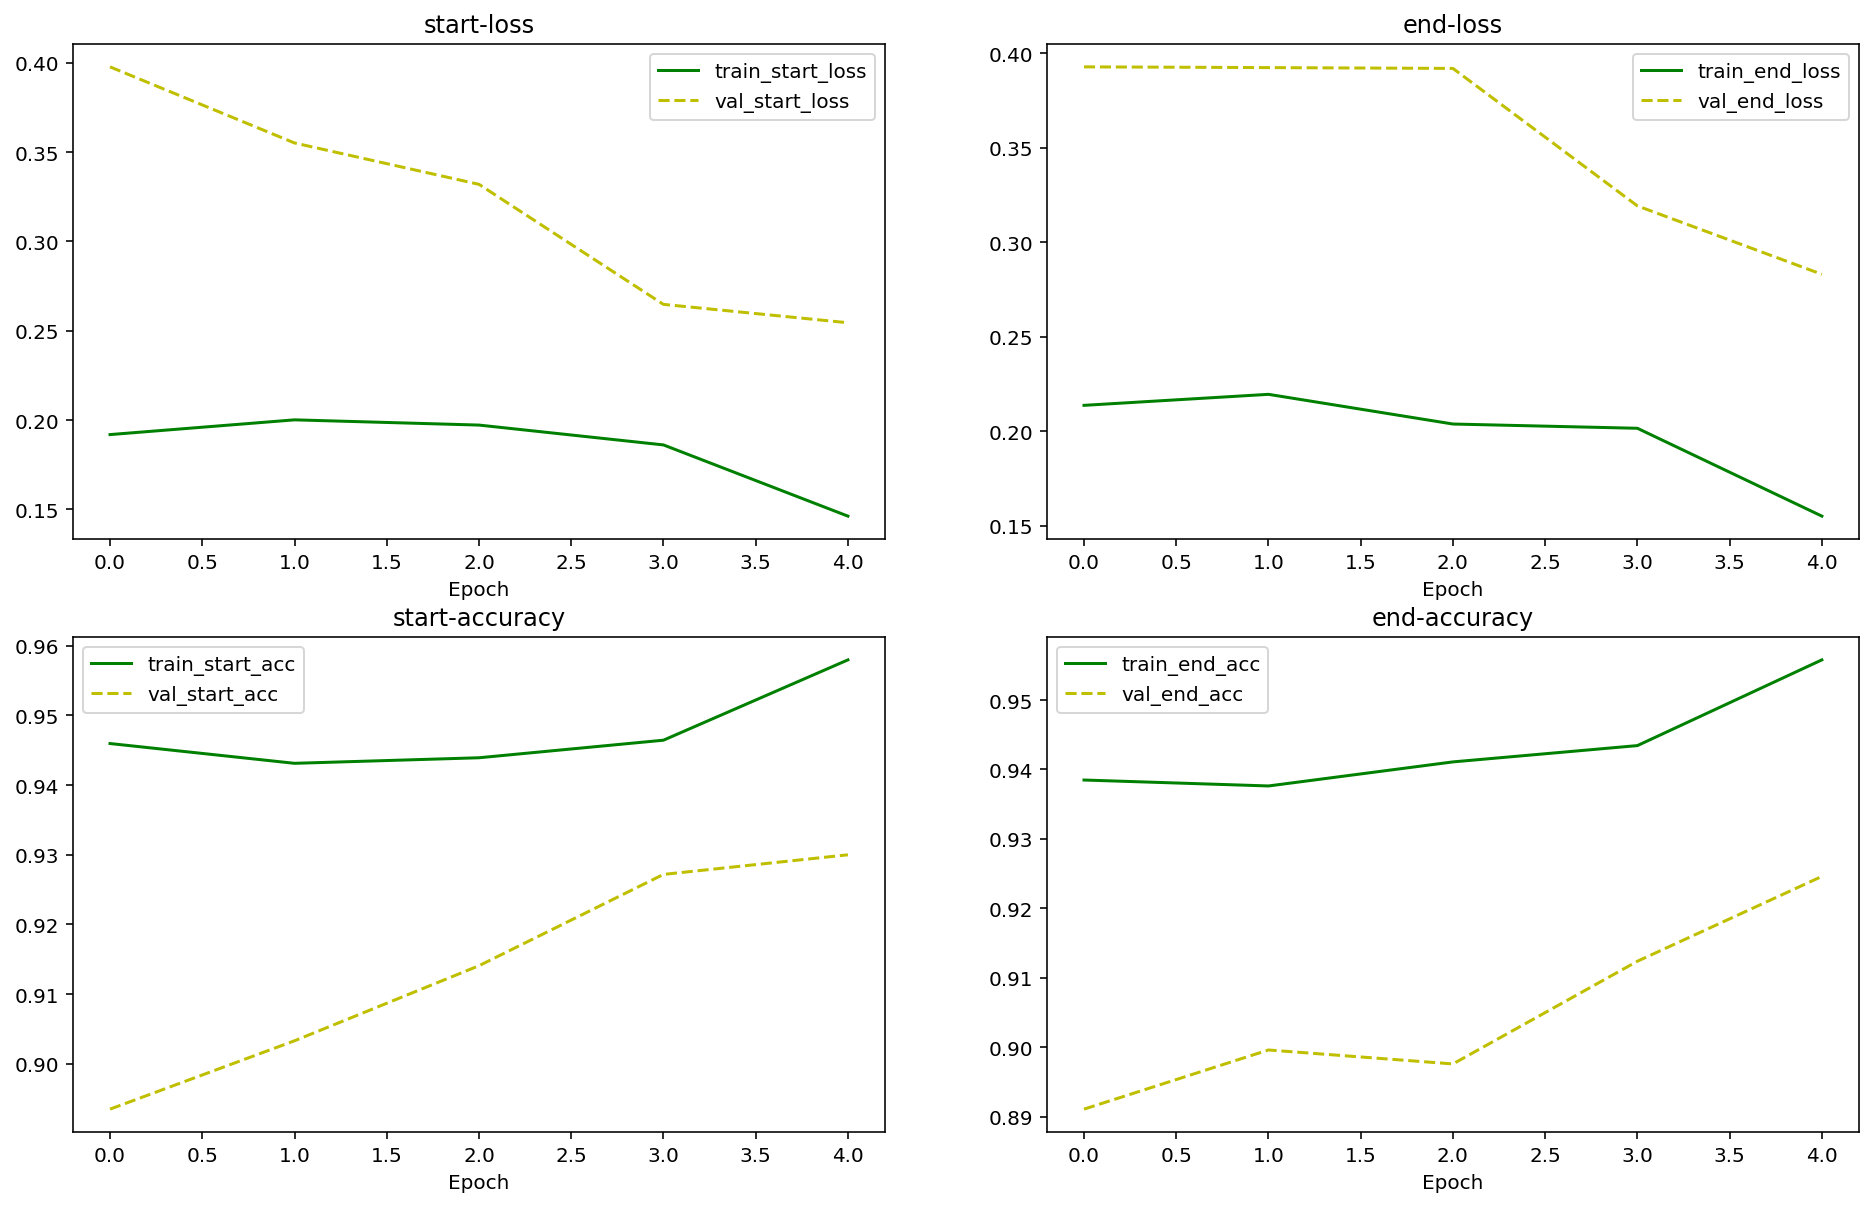

In [84]:
# 훈련이 마무리되었으면 시각화를 진행.

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(history['train_start_loss'], 'g-', label='train_start_loss')
plt.plot(history['val_start_loss'], 'y--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('start-loss')

plt.subplot(2, 2, 2)
plt.plot(history['train_end_loss'], 'g-', label='train_end_loss')
plt.plot(history['val_end_loss'], 'y--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('end-loss')

plt.subplot(2, 2, 3)
plt.plot(history['train_start_acc'], 'g-', label='train_start_acc')
plt.plot(history['val_start_acc'], 'y--', label='val_start_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('start-accuracy')


plt.subplot(2, 2, 4)
plt.plot(history['train_end_acc'], 'g-', label='train_end_acc')
plt.plot(history['val_end_acc'], 'y--', label='val_end_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('end-accuracy')

plt.show()